In [237]:
import os
import matplotlib.pyplot as plt
from OA_utils.OAPreprocessingScripts import *
from OA_utils.OpenSimScripts import *
from OA_utils.data_utils import interp_segments, ad2float
import pickle

Import all segs data

In [ ]:
root_dir = '/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/'
with open(root_dir + 'all_segs.pkl', 'rb') as f:
    all_segs = pickle.load(f)
print(all_segs)
#import dictionary of gait cycles with unrealistic muscle activations
with open(root_dir + 'problematic_activation_segs', 'rb') as f:
    problematic_activation_segs = pickle.load(f)
print(problematic_activation_segs)
problem_seg_keys = set(
    (
        d["subject"],
        d["side"].lower(),
        round(d["start_time"], 4),
        round(d["end_time"], 4),
    )
    for d in problematic_activation_segs
)

{'OA1': {'OA1_80_1': {'left': [(1.2885, 2.0735)], 'right': [(0.6945, 1.475), (1.886, 2.696)]}, 'OA1_80_2': {'left': [(1.207, 2.011)], 'right': [(0.6065, 1.4145), (1.824, 2.6345)]}, 'OA1_80_3': {'left': [(1.151, 1.9685)], 'right': [(0.543, 1.357), (1.778, 2.577)]}, 'OA1_80_4': {'left': [(1.232, 2.0545)], 'right': [(0.624, 1.433), (1.8555, 2.689)]}, 'OA1_80_5': {'left': [(1.0405, 1.837)], 'right': [(0.4395, 1.2235), (1.652, 2.4615)]}, 'OA1_100_1': {'left': [(0.912, 1.6125)], 'right': [(0.37, 1.072), (1.4565, 2.1605)]}, 'OA1_100_2': {'left': [(1.0515, 1.741)], 'right': [(0.5325, 1.214), (1.5905, 2.278)]}, 'OA1_100_3': {'left': [(0.978, 1.6435)], 'right': [(0.476, 1.1395), (1.502, 2.178)]}, 'OA1_100_4': {'left': [(0.551, 1.1595), (1.5375, 2.1985)], 'right': [(1.0135, 1.698)]}, 'OA1_100_5': {'left': [(0.8995, 1.5655)], 'right': [(0.385, 1.061), (1.418, 2.1145)]}, 'OA1_120_1': {'left': [(0.9025, 1.513)], 'right': [(0.409, 1.0285)]}, 'OA1_120_2': {'left': [(0.7965, 1.4055)], 'right': [(0.347,

In [247]:
left = 0
right = 0
for subjects, trials in all_segs.items():
    for trial_data in trials.values():
        left += len(trial_data['left'])
        right += len(trial_data['right'])
print(f'{left} left foot segments')
print(f'{right} right foot segments')
print(f'{left + right} segments total')

826 left foot segments
862 right foot segments
1688 segments total


In [261]:
def data_to_segs(muscles, seg_times, problem_trials, grf_pickle_dir, muscle_force_dir, add_achilles = True):
    compiled_segs = {}
    base_muscles = sorted({m[:-2] for m in muscles if m.endswith(("_r", "_l"))})

    # helper to read multiple columns from Storage dynamically
    def load_muscle_columns(storage, base_muscles, side_suffix):
        """
        Returns: (muscle_time, muscle_data) where muscle_data maps base name -> np array
        """
        muscle_time_col = osim.ArrayDouble()
        storage.getTimeColumn(muscle_time_col)
        muscle_time = ad2float(muscle_time_col)

        muscle_data = {}
        for m in base_muscles:
            col = osim.ArrayDouble()
            storage.getDataColumn(f"{m}_{side_suffix}", col)
            muscle_data[m] = ad2float(col)
        
        return muscle_time, muscle_data
    problematic_segs = []
    #loop thru all subjects and create their dictionary slots for each muscle specified
    for subject, trials in seg_times.items():
        compiled_segs[subject] = {
            'grf_x' : [], 'grf_y' : [], 'grf_z' : [],
            'cop_x' : [], 'cop_y' : [], 'cop_z' : [],
            **{m : [] for m in base_muscles}
        }
        if add_achilles:
            compiled_segs[subject]['achilles'] = []
        #loop thru each trial, extracting gait segments according to masks 
        for trial_name, seg_dict in trials.items():
            #load grf
            grf_path = os.path.join(grf_pickle_dir, trial_name)
            grf_df = pd.read_pickle(grf_path)
            time = grf_df['time'].values
            #load muscle data
            muscle_path = os.path.join(muscle_force_dir, trial_name, 'results_forces.sto')
            muscle_storage = osim.Storage(muscle_path)
            muscle_time, muscle_r = load_muscle_columns(storage = muscle_storage, base_muscles = base_muscles, side_suffix='r')
            _, muscle_l = load_muscle_columns(storage = muscle_storage, base_muscles = base_muscles, side_suffix='l')
        # segment loop
            for side, seg_list in seg_dict.items():
                side = side.lower()
                if side not in ("right", "left"):
                    continue
                for (s, e) in seg_list:
                    #skip segments flagged for bad activation values
                    key = (trial_name, side, round(s, 4), round(e, 4))
                    if key in problem_seg_keys:
                        continue
                    grf_mask = (time >= s) & (time <= e)
                    m_mask   = (muscle_time >= s) & (muscle_time <= e)

                    if (not grf_mask.any()) or (not m_mask.any()):
                        continue

                    # pick GRF columns based on side (matching your current naming)
                    if side == "right":
                        force_seg_x = grf_df.loc[grf_mask, "ground_force_vx"].to_numpy()
                        force_seg_y = grf_df.loc[grf_mask, "ground_force_vy"].to_numpy()
                        force_seg_z = grf_df.loc[grf_mask, "ground_force_vz"].to_numpy()
                        pressure_seg_x = grf_df.loc[grf_mask, "ground_force_new_px"].to_numpy()
                        pressure_seg_y = grf_df.loc[grf_mask, "ground_force_py"].to_numpy()
                        pressure_seg_z = grf_df.loc[grf_mask, "ground_force_pz"].to_numpy()
                        mdata = muscle_r
                    else:
                        force_seg_x = grf_df.loc[grf_mask, "1_ground_force_vx"].to_numpy()
                        force_seg_y = grf_df.loc[grf_mask, "1_ground_force_vy"].to_numpy()
                        force_seg_z = (-1.0 * grf_df.loc[grf_mask, "1_ground_force_vz"]).to_numpy()
                        pressure_seg_x = grf_df.loc[grf_mask, "1_ground_force_new_px"].to_numpy()
                        pressure_seg_y = grf_df.loc[grf_mask, "1_ground_force_py"].to_numpy()
                        pressure_seg_z = grf_df.loc[grf_mask, "1_ground_force_pz"].to_numpy()
                        mdata = muscle_l

                    
                    #filter out missteps based on y grfs
                    y_idx_25 = int(len(force_seg_y) * 0.25)
                    y_idx_75 = int(len(force_seg_y) * 0.75)
                    y_idx_10 = int(len(force_seg_y) * 0.1)
                    y_idx_1 = int(len(force_seg_y) * 0.01)
                    if len(force_seg_y) > 0 and force_seg_y[y_idx_25] < 500 or force_seg_y[y_idx_75] < 400 or force_seg_y[y_idx_1] > 300:
                        problematic_segs.append({
                            'subject': trial_name,
                            'side': side,
                            'file':grf_path,
                            'start_time': s,
                            'end_time':float(e)
                        })
                        continue

                    compiled_segs[subject]["grf_x"].append(force_seg_x)
                    compiled_segs[subject]["grf_y"].append(force_seg_y)
                    compiled_segs[subject]["grf_z"].append(force_seg_z)
                    compiled_segs[subject]["cop_x"].append(pressure_seg_x)
                    compiled_segs[subject]["cop_y"].append(pressure_seg_y)
                    compiled_segs[subject]["cop_z"].append(pressure_seg_z)

                    # muscles in a loop (the whole point)
                    seg_muscles = {}
                    for m in base_muscles:
                        seg_m = mdata[m][m_mask]
                        compiled_segs[subject][m].append(seg_m)
                        seg_muscles[m] = seg_m  # keep for achilles calc
                        
                    # optional achilles
                    if add_achilles:
                        seg_achilles = ( mdata['gaslat'][m_mask] + mdata['gasmed'][m_mask] + mdata['soleus'][m_mask])
                        compiled_segs[subject]['achilles'].append(seg_achilles)

    return compiled_segs, problematic_segs

In [279]:
muscles = [
    "addbrev_r", "addlong_r", "addmagDist_r", "addmagIsch_r", "addmagMid_r", "addmagProx_r",
    "bflh_r", "bfsh_r", "edl_r", "ehl_r", "fdl_r", "fhl_r", "gaslat_r", "gasmed_r",
    "glmax1_r", "glmax2_r", "glmax3_r", "glmed1_r", "glmed2_r", "glmed3_r",
    "glmin1_r", "glmin2_r", "glmin3_r", "grac_r", "iliacus_r", "perbrev_r", "perlong_r",
    "piri_r", "psoas_r", "recfem_r", "sart_r", "semimem_r", "semiten_r", "soleus_r", "tfl_r",
    "tibant_r", "tibpost_r", "vasint_r", "vaslat_r", "vasmed_r",

    "addbrev_l", "addlong_l", "addmagDist_l", "addmagIsch_l", "addmagMid_l", "addmagProx_l",
    "bflh_l", "bfsh_l", "edl_l", "ehl_l", "fdl_l", "fhl_l", "gaslat_l", "gasmed_l",
    "glmax1_l", "glmax2_l", "glmax3_l", "glmed1_l", "glmed2_l", "glmed3_l",
    "glmin1_l", "glmin2_l", "glmin3_l", "grac_l", "iliacus_l", "perbrev_l", "perlong_l",
    "piri_l", "psoas_l", "recfem_l", "sart_l", "semimem_l", "semiten_l",
    "soleus_l", "tfl_l", "tibant_l", "tibpost_l", "vasint_l", "vaslat_l", "vasmed_l"
]
problem_trials = []

all_muscle_segs, problematic_force_segs = data_to_segs(muscles = muscles, seg_times = all_segs, problem_trials = problem_trials, 
             grf_pickle_dir= '/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Transformed/grf_pickles',
             muscle_force_dir='/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO')

[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_80_1/results_forces.sto (nr=291 nc=118)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_80_2/results_forces.sto (nr=286 nc=118)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_80_3/results_forces.sto (nr=286 nc=118)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_80_4/results_forces.sto (nr=291 nc=118)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_80_5/results_forces.sto (nr=273 nc=118)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/Results/SO/OA1_100_1/results_forces.sto (nr=225 nc=118)
[info] Storage: read data file = /Users/briankeller/Desktop/GRFMuscleModel/Old_Yo

Check how many good gait cycles were segmented

In [281]:
n_bad_act = len(problematic_activation_segs)
print(n_bad_act, 'gait cycles filtered out for unrealistic muscle activation')
n_bad_grf = len(problematic_force_segs)
print(n_bad_grf, 'gait cycles filtered out for mis-step indicating ground reaction forces')
n_kept = sum(
    len(subj_data["grf_y"])
    for subj_data in all_muscle_segs.values()
)
print(n_kept, 'clean gait cycles')

104 gait cycles filtered out for unrealistic muscle activation
101 gait cycles filtered out for mis-step indicating ground reaction forces
1483 clean gait cycles


Summarize stats on problematic segments (Should we keep this? if yes then lets featurize it in utils and save problematic segments as a text file)

In [282]:
def summarize_segments(log_text):
    """
    Takes raw multiline text like 'Trial:OA1_80_2, start time:0.6065'
    and returns a summary count of segments per subject.
    """
    # Extract subject codes using regex (e.g. OA1, OA2, OA17, etc.)
    subjects = re.findall(r"Trial:(OA\d+)_", log_text)
    counts = Counter(subjects)

    # Print nicely formatted summary
    print(f"{'Subject':<8} {'# Segments':>10}")
    print("-" * 22)
    for subj, n in sorted(counts.items(), key=lambda x: int(x[0][2:])):  # sort by number
        print(f"{subj:<8} {n:>10}")
    print("-" * 22)
    print(f"{'Total':<8} {sum(counts.values()):>10}")

    return counts

# Example usage:
log_text = """Trial:OA1_100_1, start time:1.4565
Trial:OA1_100_2, start time:0.5325
Trial:OA1_100_3, start time:0.476
Trial:OA1_100_3, start time:1.502
Trial:OA1_120_1, start time:0.409
Trial:OA1_120_2, start time:1.2845
Trial:OA1_120_3, start time:0.1845
Trial:OA1_120_5, start time:1.2495
Trial:OA2_80_2, start time:1.339
Trial:OA2_100_1, start time:0.809
Trial:OA2_100_1, start time:0.2815
Trial:OA2_100_2, start time:0.8135
Trial:OA2_100_3, start time:0.8485
Trial:OA2_100_3, start time:0.3385
Trial:OA2_100_4, start time:0.736
Trial:OA2_100_4, start time:0.232
Trial:OA2_100_5, start time:0.4415
Trial:OA2_120_1, start time:1.114
Trial:OA2_120_1, start time:0.64
Trial:OA2_120_2, start time:0.7325
Trial:OA2_120_2, start time:0.256
Trial:OA2_120_3, start time:0.8145
Trial:OA2_120_3, start time:0.346
Trial:OA2_120_3, start time:1.2945
Trial:OA2_120_4, start time:0.7515
Trial:OA2_120_4, start time:0.3035
Trial:OA2_120_5, start time:0.745
Trial:OA2_120_5, start time:0.2935
Trial:OA4_80_2, start time:2.0095
Trial:OA4_80_3, start time:2.1885
Trial:OA4_80_4, start time:2.2195
Trial:OA4_80_5, start time:2.438
Trial:OA4_100_3, start time:1.6275
Trial:OA4_100_4, start time:1.8865
Trial:OA4_120_1, start time:1.4345
Trial:OA5_80_1, start time:0.556
Trial:OA5_80_1, start time:1.7535
Trial:OA5_80_2, start time:0.744
Trial:OA5_80_2, start time:1.913
Trial:OA5_80_3, start time:0.7885
Trial:OA5_80_4, start time:0.8025
Trial:OA5_80_4, start time:1.929
Trial:OA5_80_5, start time:0.6295
Trial:OA5_80_5, start time:1.7805
Trial:OA5_100_1, start time:1.187
Trial:OA5_100_1, start time:0.695
Trial:OA5_100_2, start time:0.914
Trial:OA5_100_2, start time:0.4095
Trial:OA5_100_3, start time:1.0135
Trial:OA5_100_3, start time:0.6055
Trial:OA5_100_4, start time:0.6085
Trial:OA5_100_4, start time:1.639
Trial:OA5_100_4, start time:1.131
Trial:OA5_100_5, start time:0.69
Trial:OA5_100_5, start time:1.701
Trial:OA5_120_1, start time:0.959
Trial:OA5_120_1, start time:0.487
Trial:OA5_120_1, start time:1.4395
Trial:OA5_120_2, start time:0.9525
Trial:OA5_120_2, start time:0.472
Trial:OA5_120_2, start time:1.4225
Trial:OA5_120_3, start time:0.909
Trial:OA5_120_3, start time:0.4315
Trial:OA5_120_3, start time:1.3895
Trial:OA5_120_4, start time:0.942
Trial:OA5_120_4, start time:0.4685
Trial:OA5_120_5, start time:1.1125
Trial:OA5_120_5, start time:0.65
Trial:OA7_80_3, start time:2.089
Trial:OA7_100_1, start time:0.619
Trial:OA7_100_1, start time:1.642
Trial:OA7_100_2, start time:1.614
Trial:OA7_100_3, start time:0.582
Trial:OA7_100_4, start time:0.479
Trial:OA7_100_4, start time:1.477
Trial:OA7_100_5, start time:0.572
Trial:OA7_120_1, start time:0.8175
Trial:OA7_120_1, start time:0.3965
Trial:OA7_120_1, start time:1.279
Trial:OA7_120_2, start time:0.9555
Trial:OA7_120_2, start time:0.488
Trial:OA7_120_3, start time:0.8445
Trial:OA7_120_3, start time:0.4095
Trial:OA7_120_3, start time:1.293
Trial:OA7_120_4, start time:0.9475
Trial:OA7_120_4, start time:0.511
Trial:OA7_120_4, start time:1.393
Trial:OA7_120_5, start time:0.8355
Trial:OA7_120_5, start time:0.3985
Trial:OA7_120_5, start time:1.2885
Trial:OA8_100_2, start time:1.2055
Trial:OA8_100_4, start time:1.3925
Trial:OA9_100_1, start time:1.7055
Trial:OA9_120_3, start time:1.219
Trial:OA9_120_4, start time:1.28
Trial:OA10_100_1, start time:1.479
Trial:OA10_100_4, start time:1.557
Trial:OA10_100_5, start time:1.5895
Trial:OA10_120_1, start time:0.489
Trial:OA10_120_1, start time:1.019
Trial:OA10_120_2, start time:0.7775
Trial:OA10_120_3, start time:0.8285
Trial:OA10_120_5, start time:0.9075
Trial:OA11_80_1, start time:0.342
Trial:OA11_80_1, start time:0.8455
Trial:OA11_80_2, start time:0.5475
Trial:OA11_80_3, start time:0.3955
Trial:OA11_80_3, start time:1.0305
Trial:OA11_80_4, start time:0.487
Trial:OA11_80_5, start time:0.378
Trial:OA11_80_5, start time:1.0065
Trial:OA11_100_1, start time:0.2415
Trial:OA11_100_1, start time:1.2085
Trial:OA11_100_1, start time:0.711
Trial:OA11_100_2, start time:0.411
Trial:OA11_100_3, start time:0.6215
Trial:OA11_100_4, start time:0.215
Trial:OA11_100_4, start time:0.7025
Trial:OA11_100_5, start time:0.9085
Trial:OA11_120_1, start time:0.978
Trial:OA11_120_2, start time:0.737
Trial:OA11_120_3, start time:0.622
Trial:OA11_120_4, start time:0.836
Trial:OA11_120_5, start time:0.7705
Trial:OA12_80_1, start time:1.7915
Trial:OA12_80_2, start time:0.5585
Trial:OA12_80_2, start time:1.818
Trial:OA12_80_3, start time:0.5535
Trial:OA12_80_3, start time:1.77
Trial:OA12_80_4, start time:0.2385
Trial:OA12_80_4, start time:1.407
Trial:OA12_80_5, start time:0.3675
Trial:OA12_80_5, start time:1.52
Trial:OA12_100_1, start time:0.8195
Trial:OA12_100_2, start time:0.6945
Trial:OA12_100_2, start time:0.2545
Trial:OA12_100_3, start time:0.9315
Trial:OA12_100_3, start time:1.4485
Trial:OA12_100_4, start time:0.3725
Trial:OA12_100_4, start time:1.4645
Trial:OA12_100_5, start time:0.8105
Trial:OA12_100_5, start time:0.2665
Trial:OA12_120_1, start time:0.9575
Trial:OA12_120_2, start time:0.9975
Trial:OA12_120_2, start time:0.4345
Trial:OA12_120_3, start time:0.6695
Trial:OA12_120_3, start time:0.202
Trial:OA12_120_4, start time:0.7345
Trial:OA12_120_4, start time:0.2265
Trial:OA12_120_5, start time:0.697
Trial:OA12_120_5, start time:0.198
Trial:OA13_100_4, start time:1.622
Trial:OA13_120_5, start time:0.2845
Trial:OA14_80_1, start time:2.1175
Trial:OA17_80_1, start time:2.181
Trial:OA17_80_1, start time:1.53
Trial:OA17_80_2, start time:2.002
Trial:OA17_80_2, start time:1.41
Trial:OA17_80_3, start time:1.9795
Trial:OA17_80_3, start time:1.4085
Trial:OA17_80_4, start time:1.0805
Trial:OA17_80_5, start time:1.329
Trial:OA17_100_1, start time:0.258
Trial:OA17_100_1, start time:1.373
Trial:OA17_100_2, start time:0.3955
Trial:OA17_100_2, start time:1.3875
Trial:OA17_100_3, start time:0.2965
Trial:OA17_100_3, start time:1.3575
Trial:OA17_100_4, start time:0.277
Trial:OA17_100_4, start time:1.2795
Trial:OA17_100_5, start time:0.399
Trial:OA17_100_5, start time:1.494
Trial:OA17_120_1, start time:0.778
Trial:OA17_120_1, start time:0.302
Trial:OA17_120_2, start time:0.851
Trial:OA17_120_2, start time:0.3895
Trial:OA17_120_3, start time:0.6605
Trial:OA17_120_3, start time:0.206
Trial:OA17_120_4, start time:0.8815
Trial:OA17_120_4, start time:0.3045
Trial:OA17_120_5, start time:0.8315
Trial:OA17_120_5, start time:0.368
Trial:OA18_80_3, start time:0.405
Trial:OA18_80_3, start time:1.693
Trial:OA18_80_3, start time:1.05
Trial:OA18_100_2, start time:1.2335
Trial:OA19_80_1, start time:0.5435
Trial:OA19_80_1, start time:1.724
Trial:OA19_80_2, start time:0.37
Trial:OA19_80_2, start time:1.5215
Trial:OA19_80_3, start time:0.3135
Trial:OA19_80_3, start time:1.475
Trial:OA19_80_4, start time:0.153
Trial:OA19_80_4, start time:1.2245
Trial:OA19_80_5, start time:0.295
Trial:OA19_80_5, start time:1.5025
Trial:OA19_100_1, start time:0.8305
Trial:OA19_100_1, start time:0.395
Trial:OA19_100_2, start time:0.311
Trial:OA19_100_3, start time:0.3
Trial:OA19_100_4, start time:0.7865
Trial:OA19_100_4, start time:0.4
Trial:OA19_100_5, start time:0.331
Trial:OA19_120_1, start time:0.745
Trial:OA19_120_1, start time:0.319
Trial:OA19_120_2, start time:0.878
Trial:OA19_120_2, start time:0.4775
Trial:OA19_120_3, start time:0.147
Trial:OA19_120_3, start time:0.699
Trial:OA19_120_4, start time:0.2195
Trial:OA19_120_4, start time:0.778
Trial:OA19_120_5, start time:0.191
Trial:OA19_120_5, start time:0.737
Trial:OA20_80_1, start time:1.604
Trial:OA20_80_2, start time:1.401
Trial:OA20_80_3, start time:0.9535
Trial:OA20_80_3, start time:0.391
Trial:OA20_80_4, start time:0.888
Trial:OA20_80_4, start time:1.493
Trial:OA20_80_5, start time:0.8685
Trial:OA20_80_5, start time:1.5025
Trial:OA20_100_1, start time:0.225
Trial:OA20_100_1, start time:1.258
Trial:OA20_100_1, start time:0.749
Trial:OA20_100_2, start time:0.309
Trial:OA20_100_2, start time:1.3375
Trial:OA20_100_2, start time:0.8345
Trial:OA20_100_3, start time:0.3275
Trial:OA20_100_3, start time:1.3655
Trial:OA20_100_3, start time:0.8455
Trial:OA20_100_4, start time:0.3985
Trial:OA20_100_4, start time:1.4035
Trial:OA20_100_4, start time:0.9085
Trial:OA20_100_5, start time:0.2375
Trial:OA20_100_5, start time:1.2545
Trial:OA20_100_5, start time:0.755
Trial:OA20_120_1, start time:0.252
Trial:OA20_120_1, start time:1.1175
Trial:OA20_120_1, start time:0.693
Trial:OA20_120_2, start time:0.0835
Trial:OA20_120_2, start time:0.93
Trial:OA20_120_2, start time:0.508
Trial:OA20_120_3, start time:0.354
Trial:OA20_120_3, start time:1.189
Trial:OA20_120_3, start time:0.76
Trial:OA20_120_4, start time:0.2595
Trial:OA20_120_4, start time:0.6915
Trial:OA20_120_5, start time:0.183
Trial:OA20_120_5, start time:1.0165
Trial:OA20_120_5, start time:0.6045
Trial:OA22_80_1, start time:1.308
Trial:OA22_80_2, start time:1.564
Trial:OA22_80_3, start time:1.155
Trial:OA22_80_4, start time:1.444
Trial:OA22_80_5, start time:1.477
Trial:OA22_100_1, start time:0.4615
Trial:OA22_100_1, start time:1.586
Trial:OA22_100_5, start time:1.765
Trial:OA22_120_1, start time:0.464
Trial:OA22_120_2, start time:0.203
Trial:OA22_120_5, start time:0.405
Trial:OA22_120_5, start time:1.4065
Trial:OA23_100_2, start time:1.705
Trial:OA23_100_3, start time:1.4865
Trial:OA23_100_4, start time:1.6455
Trial:OA23_100_5, start time:1.706
Trial:OA23_120_1, start time:0.6465
Trial:OA23_120_2, start time:0.7195
Trial:OA23_120_3, start time:0.7555
Trial:OA23_120_3, start time:1.2335
Trial:OA23_120_4, start time:0.598
Trial:OA23_120_5, start time:0.816
Trial:OA24_100_1, start time:1.1635
Trial:OA24_100_2, start time:1.1075
Trial:OA24_120_4, start time:0.689
Trial:OA25_120_1, start time:0.413
Trial:OA25_120_1, start time:1.4345
Trial:OA25_120_2, start time:1.202
Trial:OA25_120_3, start time:0.2385
Trial:OA25_120_3, start time:1.2645
Trial:OA25_120_4, start time:1.203
Trial:OA25_120_5, start time:0.346
Trial:OA25_120_5, start time:1.337"""
summarize_segments(log_text)

Subject  # Segments
----------------------
OA1               8
OA2              20
OA4               7
OA5              33
OA7              22
OA8               2
OA9               3
OA10              8
OA11             21
OA12             27
OA13              2
OA14              1
OA17             28
OA18              4
OA19             27
OA20             37
OA22             12
OA23             10
OA24              3
OA25              8
----------------------
Total           283


Counter({'OA20': 37,
         'OA5': 33,
         'OA17': 28,
         'OA12': 27,
         'OA19': 27,
         'OA7': 22,
         'OA11': 21,
         'OA2': 20,
         'OA22': 12,
         'OA23': 10,
         'OA1': 8,
         'OA10': 8,
         'OA25': 8,
         'OA4': 7,
         'OA18': 4,
         'OA9': 3,
         'OA24': 3,
         'OA8': 2,
         'OA13': 2,
         'OA14': 1})

In [283]:
all_subj_segs = {}
keys = next(iter(all_muscle_segs.values())).keys()
for key in keys:
   all_subj_segs[f'{key}_segments'] = [seg for subj_data in all_muscle_segs.values() for seg in subj_data.get(key, [])]

In [284]:
n_interp_points = 100
resampled_segs = {}

for subj, subj_data in all_muscle_segs.items():
    resampled_segs[subj] = {}
    for key, seg_list in subj_data.items():
        if len(seg_list) == 0:
            resampled_segs[subj][key] = []
            continue 
        resampled, time_resampled = interp_segments(seg_list, n_interp_points)
        resampled_segs[subj][key] = resampled
resampled_segs['time_resampled'] = time_resampled

def get_all_segments(resampled_segs, key):
    """
    Collects all resampled segments for a given signal across all subjects.
    """
    all_segs = []
    for subj, data in resampled_segs.items():
        if subj == "time_resampled":
            continue
        if key in data:
            all_segs.extend(data[key])
    return np.array(all_segs)

Plot Segmented GRF Data

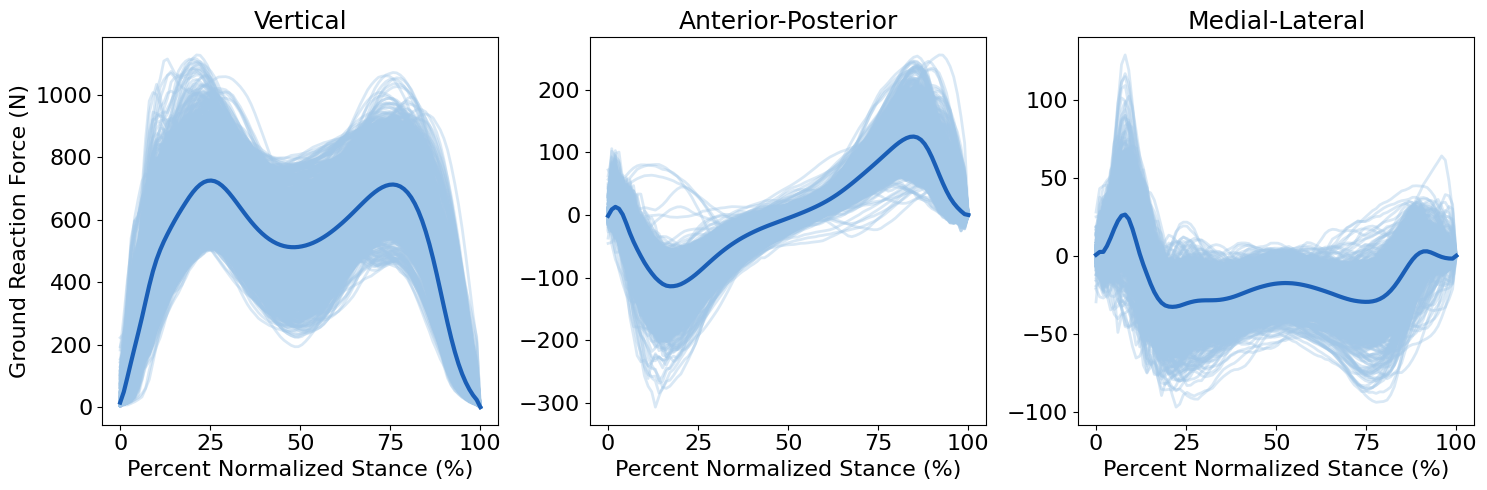

In [285]:
grf_y_resampled = get_all_segments(resampled_segs, 'grf_y')
time_resampled = resampled_segs['time_resampled']
grf_x_resampled = get_all_segments(resampled_segs, 'grf_x')
time_resampled = resampled_segs['time_resampled']
grf_z_resampled = get_all_segments(resampled_segs, 'grf_z')
time_resampled = resampled_segs['time_resampled']
# Stack into arrays
grf_y = np.array(grf_y_resampled)
grf_x = np.array(grf_x_resampled)
grf_z = np.array(grf_z_resampled)
time = time_resampled[0] * 100  # percent stance

# Set up 3-column subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Define GRF components
components = [
    ("Vertical", grf_y),
    ("Anterior-Posterior", grf_x),
    ("Medial-Lateral", grf_z)
]

colors = {
    'fill': '#5190E4',
    'line': '#1A5EB6'
}
num_grf_segments = len(grf_y_resampled)
for ax, (label, grf_array) in zip(axes, components):
    mean_grf = np.mean(grf_array, axis=0)
    
    for i in range(num_grf_segments):
        ax.plot(time, grf_array[i], linewidth=2, color="#A2C7E7", alpha=0.4)

    # Mean line
    ax.plot(time, mean_grf, color=colors['line'], linewidth=3, label='Mean GRF')
    
    ax.set_title(f"{label}", fontsize=18)
    ax.set_xlabel("Percent Normalized Stance (%)", fontsize=16)
    ax.tick_params(axis='both', labelsize=16)
    # ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Ground Reaction Force (N)", fontsize=16)
# axes[0].legend(fontsize=12)

plt.tight_layout()
plt.show()

Plot COP Data

In [286]:
cop_x_resampled = get_all_segments(resampled_segs, 'cop_x')
time_resampled = resampled_segs['time_resampled']

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6]),
 [Text(0, -0.6000000000000001, '−0.6'),
  Text(0, -0.4000000000000001, '−0.4'),
  Text(0, -0.20000000000000007, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.19999999999999996, '0.2'),
  Text(0, 0.3999999999999999, '0.4'),
  Text(0, 0.6000000000000001, '0.6')])

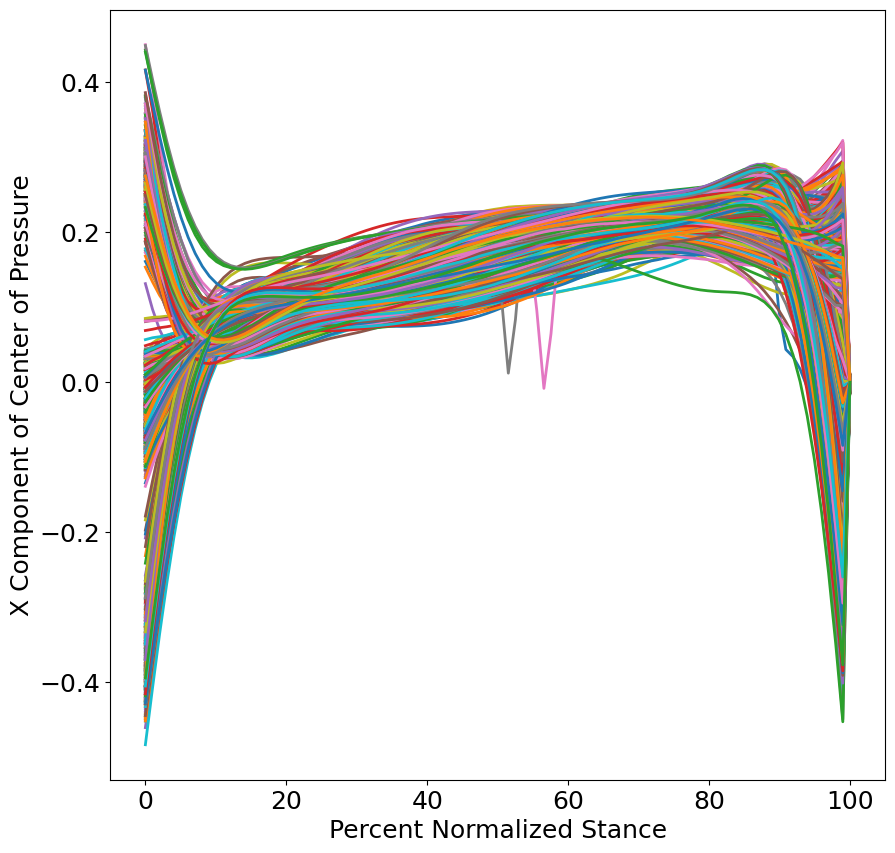

In [287]:
figure = plt.figure(figsize=(10, 10))

num_cop_segments = len(cop_x_resampled)

for i in range(num_cop_segments):
    plt.plot(time_resampled[0] * 100, cop_x_resampled[i], linewidth=2)

plt.ylabel("X Component of Center of Pressure", fontsize=18)
plt.xlabel("Percent Normalized Stance", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.xlim([0, 1])
# plt.ylim([0, 1200])

In [288]:
base_muscles = sorted({m[:-2] for m in muscles if m.endswith(("_r", "_l"))})
base_muscles.append('achilles')
resampled_muscles = {
    m: get_all_segments(resampled_segs, m)
    for m in base_muscles
}

time_resampled = resampled_segs["time_resampled"]

In [289]:
def plot_achilles_segments(achilles_resampled, time_resampled, figsize=(10, 10), linewidth=2):
    """
    achilles_resampled: list/array of segments, each shape (T,)
    time_resampled: typically resampled_segs['time_resampled'] where time_resampled[0] is (T,)
    """
    fig = plt.figure(figsize=figsize)

    num_segments = len(achilles_resampled)
    x = time_resampled[0] * 100  # percent stance

    for i in range(num_segments):
        plt.plot(x, achilles_resampled[i], linewidth=linewidth)

    plt.ylabel("Achilles Muscle Force (N)", fontsize=18)
    plt.xlabel("Percent Normalized Stance", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()


def plot_muscle_grid(
    resampled_muscles,
    time_resampled,
    muscle_keys,
    nrows=11,
    ncols=4,
    figsize=(15, 25),
    alpha=0.4,
    linewidth=2,
    plot_mean=True,
    mean_linewidth=3,
):
    """
    resampled_muscles[muscle] -> list or array of (N_segments, T)
    time_resampled[0] -> (T,) in [0,1]
    muscle_keys -> list of base muscle names (strings)
    """

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    x = time_resampled[0] * 100  # percent stance

    for i, ax in enumerate(axes):
        if i >= len(muscle_keys):
            ax.axis("off")
            continue

        key = muscle_keys[i]
        segments = resampled_muscles[key]

        # plot all segments
        for seg in segments:
            ax.plot(x, seg, linewidth=linewidth, color="#A2C7E7", alpha=alpha)

        # mean curve
        if plot_mean and len(segments) > 0:
            Y = np.asarray(segments)
            if Y.ndim == 2:
                ax.plot(x, Y.mean(axis=0), linewidth=mean_linewidth)

        # labels
        if i >= (nrows - 1) * ncols:
            ax.set_xlabel("Percent Normalized Stance", fontsize=12)
        if i % ncols == 0:
            ax.set_ylabel("Muscle Force (N)", fontsize=12)

        # auto title from key
        title = key.replace("_", " ").title()
        ax.set_title(title, fontsize=18)

        ax.tick_params(axis="x", labelsize=16)
        ax.tick_params(axis="y", labelsize=16)

    plt.tight_layout()
    plt.show()

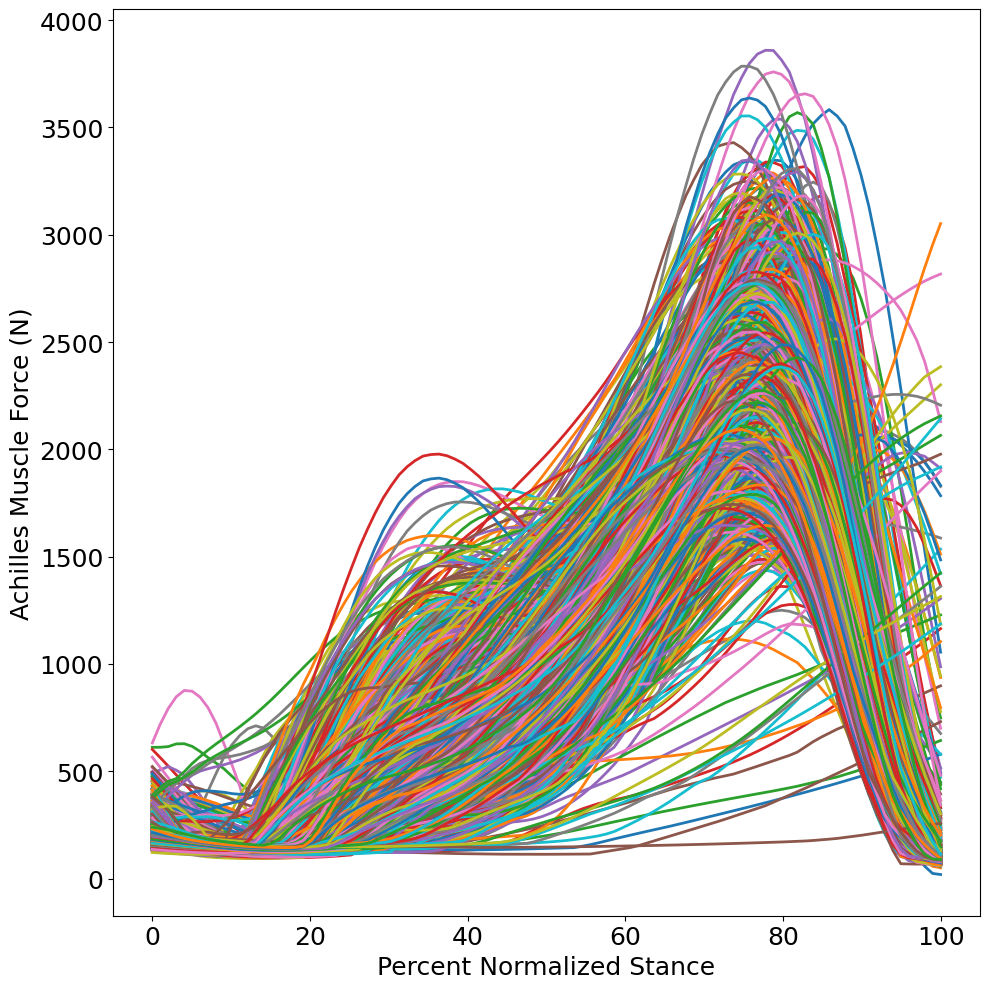

In [290]:
plot_achilles_segments(resampled_muscles['achilles'], time_resampled)

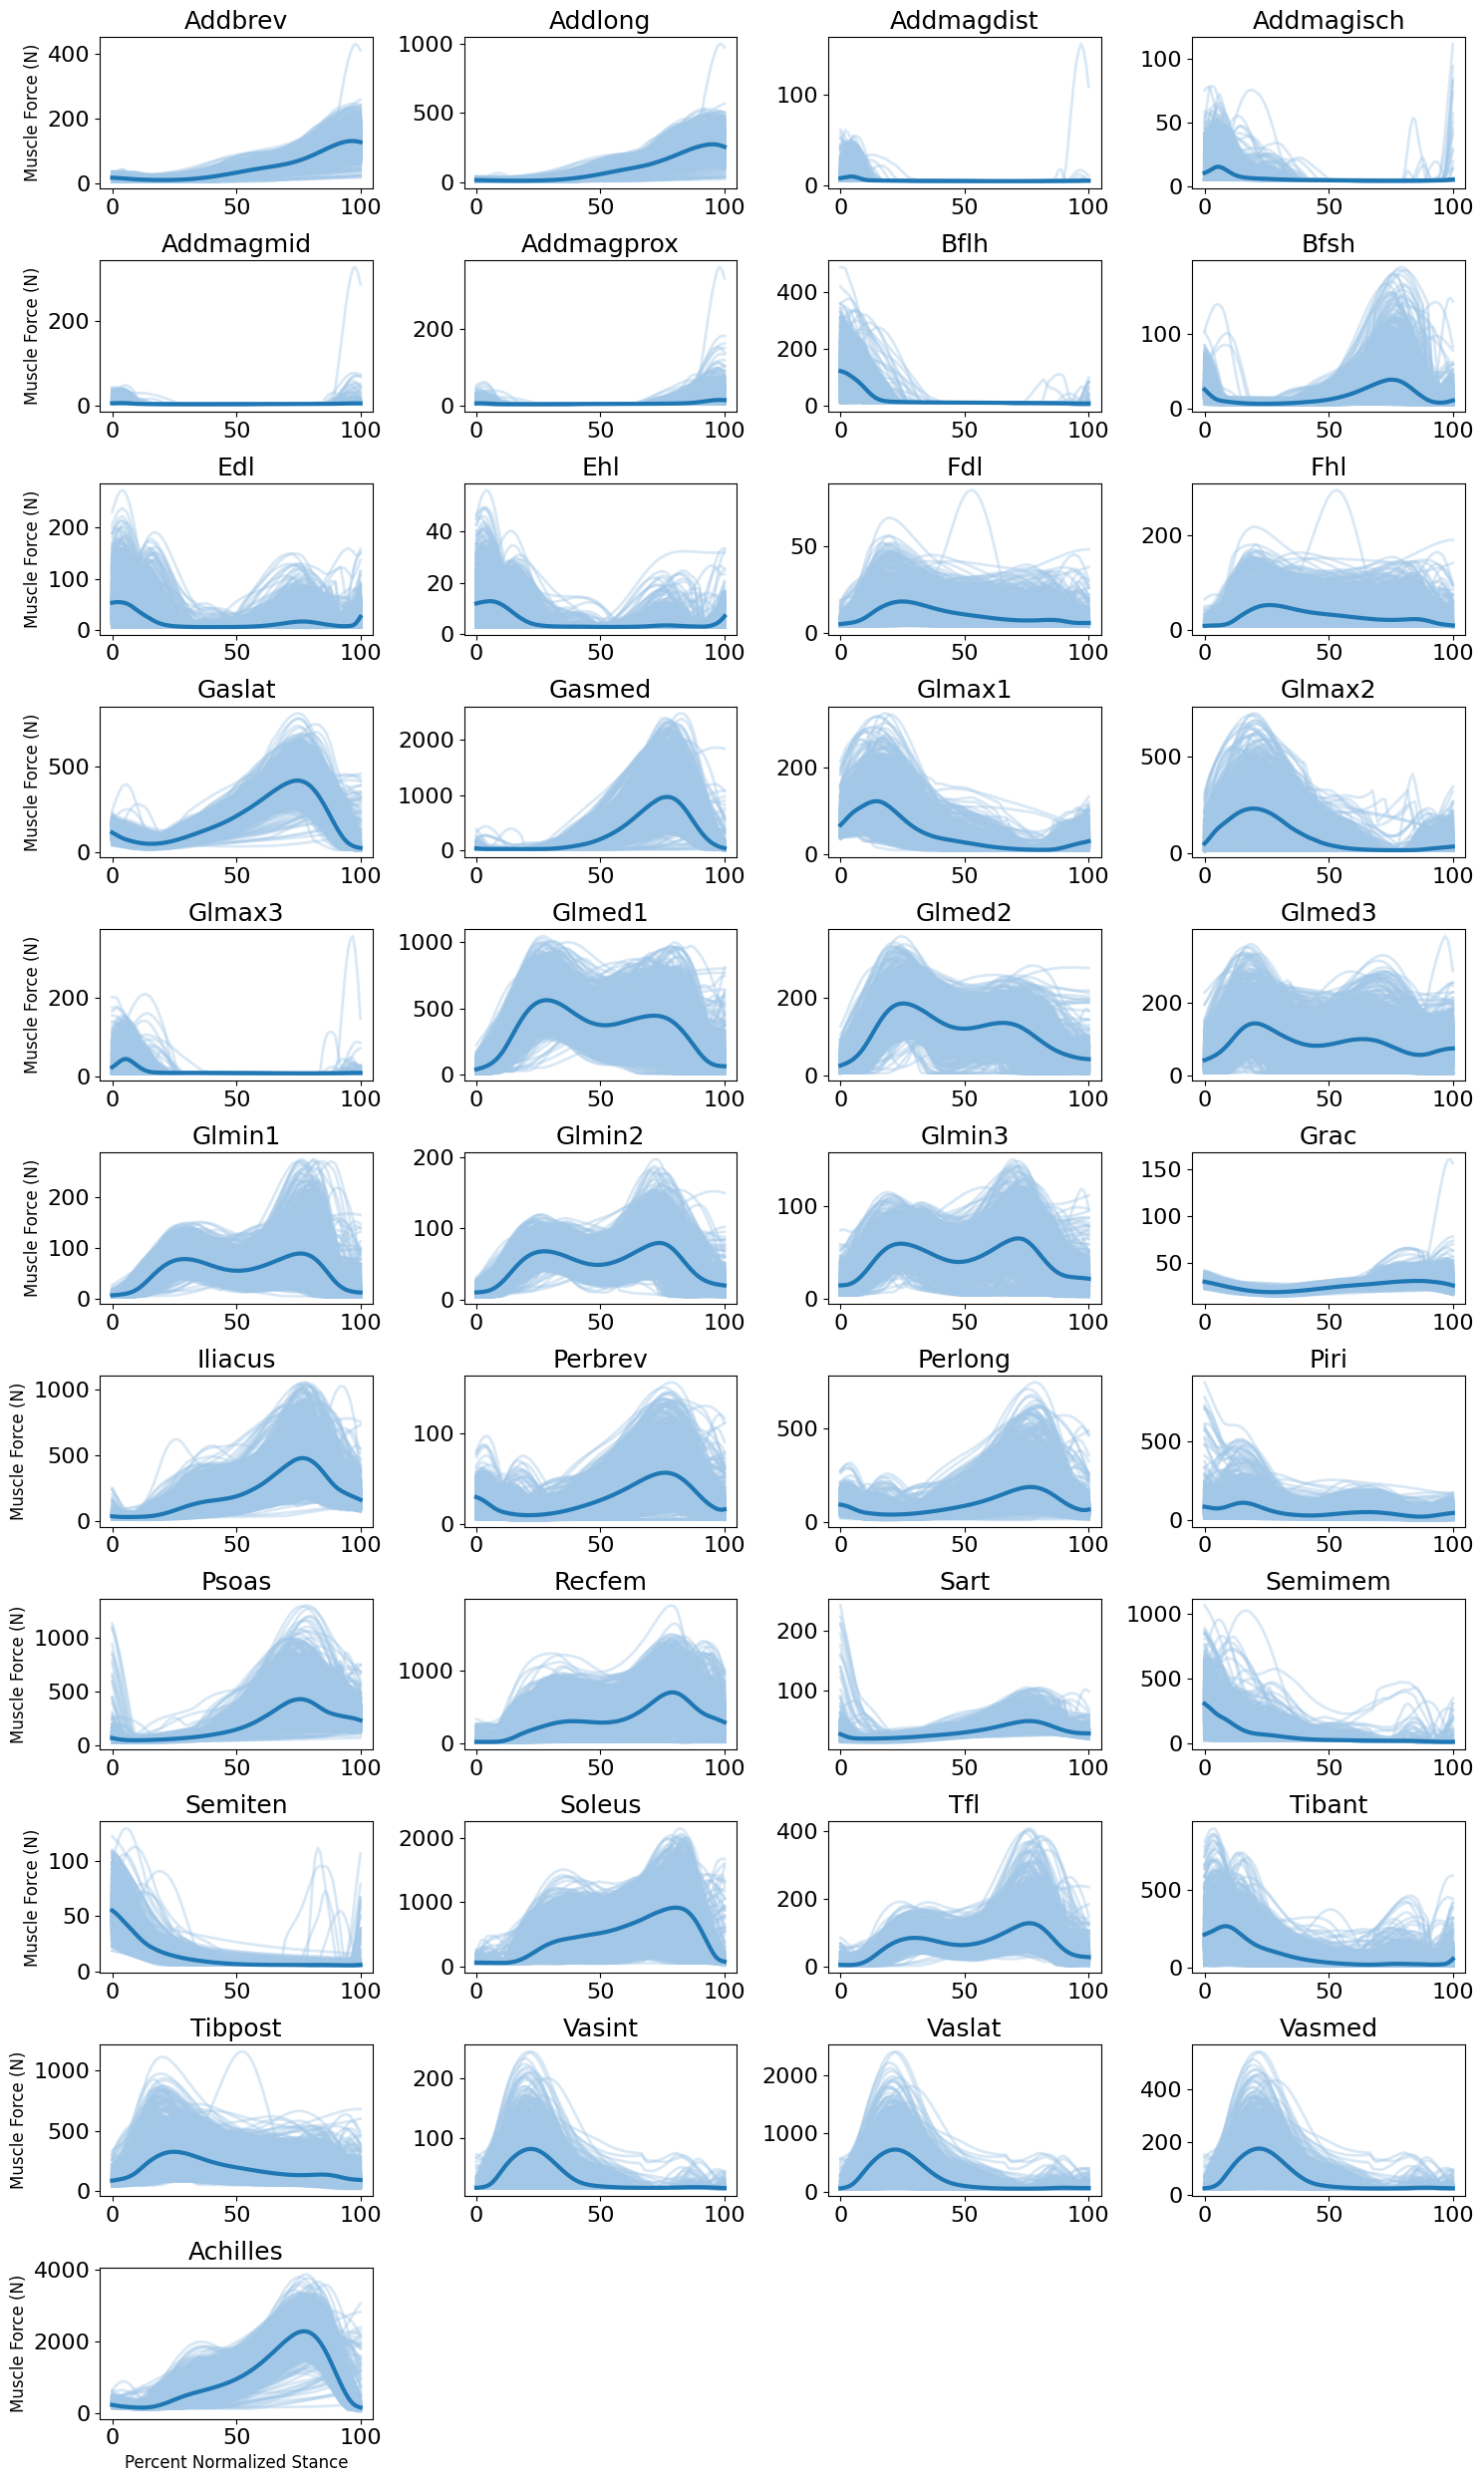

In [291]:
plot_muscle_grid(
    resampled_muscles,
    time_resampled,
    base_muscles,
    plot_mean=True
)

In [117]:
# tibpost_segments = all_subj_segs['tibpost_segments']
# tibant_segments = all_subj_segs['tibant_segments']
# edl_segments = all_subj_segs['edl_segments']
# ehl_segments = all_subj_segs['ehl_segments']
# fdl_segments = all_subj_segs['fdl_segments']
# fhl_segments = all_subj_segs['fhl_segments']
# gaslat_segments = all_subj_segs['gaslat_segments']
# gasmed_segments = all_subj_segs['gasmed_segments']
# soleus_segments = all_subj_segs['soleus_segments']
# perbrev_segments = all_subj_segs['perbrev_segments']
# perlong_segments = all_subj_segs['perlong_segments']
# achilles_segments = all_subj_segs['achilles_segments']

# tibpost_resampled, time_resampled = interp_segments(tibpost_segments, n_interp_points)
# tibant_resampled, time_resampled = interp_segments(tibant_segments, n_interp_points)
# edl_resampled, time_resampled = interp_segments(edl_segments, n_interp_points)
# ehl_resampled, time_resampled = interp_segments(ehl_segments, n_interp_points)
# fdl_resampled, time_resampled = interp_segments(fdl_segments, n_interp_points)
# fhl_resampled, time_resampled = interp_segments(fhl_segments, n_interp_points)
# gaslat_resampled, time_resampled = interp_segments(gaslat_segments, n_interp_points)
# gasmed_resampled, time_resampled = interp_segments(gasmed_segments, n_interp_points)
# soleus_resampled, time_resampled = interp_segments(soleus_segments, n_interp_points)
# perbrev_resampled, time_resampled = interp_segments(perbrev_segments, n_interp_points)
# perlong_resampled, time_resampled = interp_segments(perlong_segments, n_interp_points)

# achilles_resampled, time_resampled = interp_segments(achilles_segments, n_interp_points)

tibpost_resampled = get_all_segments(resampled_segs, 'tibpost')
tibant_resampled = get_all_segments(resampled_segs, 'tibant')
edl_resampled = get_all_segments(resampled_segs, 'edl')
ehl_resampled = get_all_segments(resampled_segs, 'ehl')
fdl_resampled = get_all_segments(resampled_segs, 'fdl')
fhl_resampled = get_all_segments(resampled_segs, 'fhl')
gaslat_resampled = get_all_segments(resampled_segs, 'gaslat')
gasmed_resampled = get_all_segments(resampled_segs, 'gasmed')
soleus_resampled = get_all_segments(resampled_segs, 'soleus')
perbrev_resampled = get_all_segments(resampled_segs, 'perbrev')
perlong_resampled = get_all_segments(resampled_segs, 'perlong')
achilles_resampled = get_all_segments(resampled_segs, 'achilles')

time_resampled = resampled_segs['time_resampled']


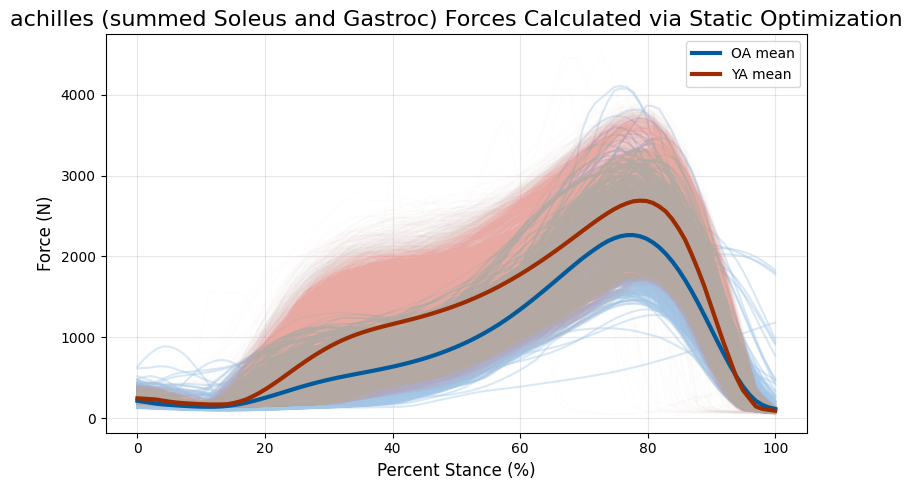

In [120]:

# --- Load Tony’s dataset ---
tony_dir = '/Users/briankeller/Desktop/GRFMuscleModel/data/'
tony_muscle_data = np.load(tony_dir + 'muscle.npy', mmap_mode='r')
n_tony_trials, n_timepoints, n_muscles = tony_muscle_data.shape

tony_muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']

# --- Pick the muscle index you want to plot ---
muscle_idx = 8  # Achilles (0-based index)
muscle_name = tony_muscle_labels[muscle_idx]

# --- Create figure ---
plt.figure(figsize=(8, 5))

# --- Plot OA data (yours) ---
for j in range(num_achilles_segments):
    plt.plot(
        time_resampled[0] * 100,
        muscle_forces[muscle_idx][j],
        color="#A2C7E7",
        linewidth=1.5,
        alpha=0.4
    )

# --- Plot Tony’s data (YA) ---
for k in range(n_tony_trials):
    plt.plot(
        np.linspace(0, 100, n_timepoints),
        tony_muscle_data[k, :, muscle_idx],
        color="#E7A9A2",
        linewidth=1.0,
        alpha=0.02
    )

# --- Plot mean lines ---
oa_mean = np.mean(np.vstack(muscle_forces[muscle_idx]), axis=0)
ya_mean = np.mean(tony_muscle_data[:, :, muscle_idx], axis=0)

plt.plot(time_resampled[0] * 100, oa_mean, color="#005A9C", linewidth=3, label='OA mean')
plt.plot(np.linspace(0, 100, n_timepoints), ya_mean, color="#9C2B00", linewidth=3, label='YA mean')

# --- Labels and formatting ---
plt.title(f'{muscle_name} (summed Soleus and Gastroc) Forces Calculated via Static Optimization', fontsize=16)
plt.xlabel('Percent Stance (%)', fontsize=12)
plt.ylabel('Force (N)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/ry/__2whx491kl275m5nl07mrnr0000gn/T/ipykernel_14236/689774793.py:52: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/envs/opensim_scripting/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


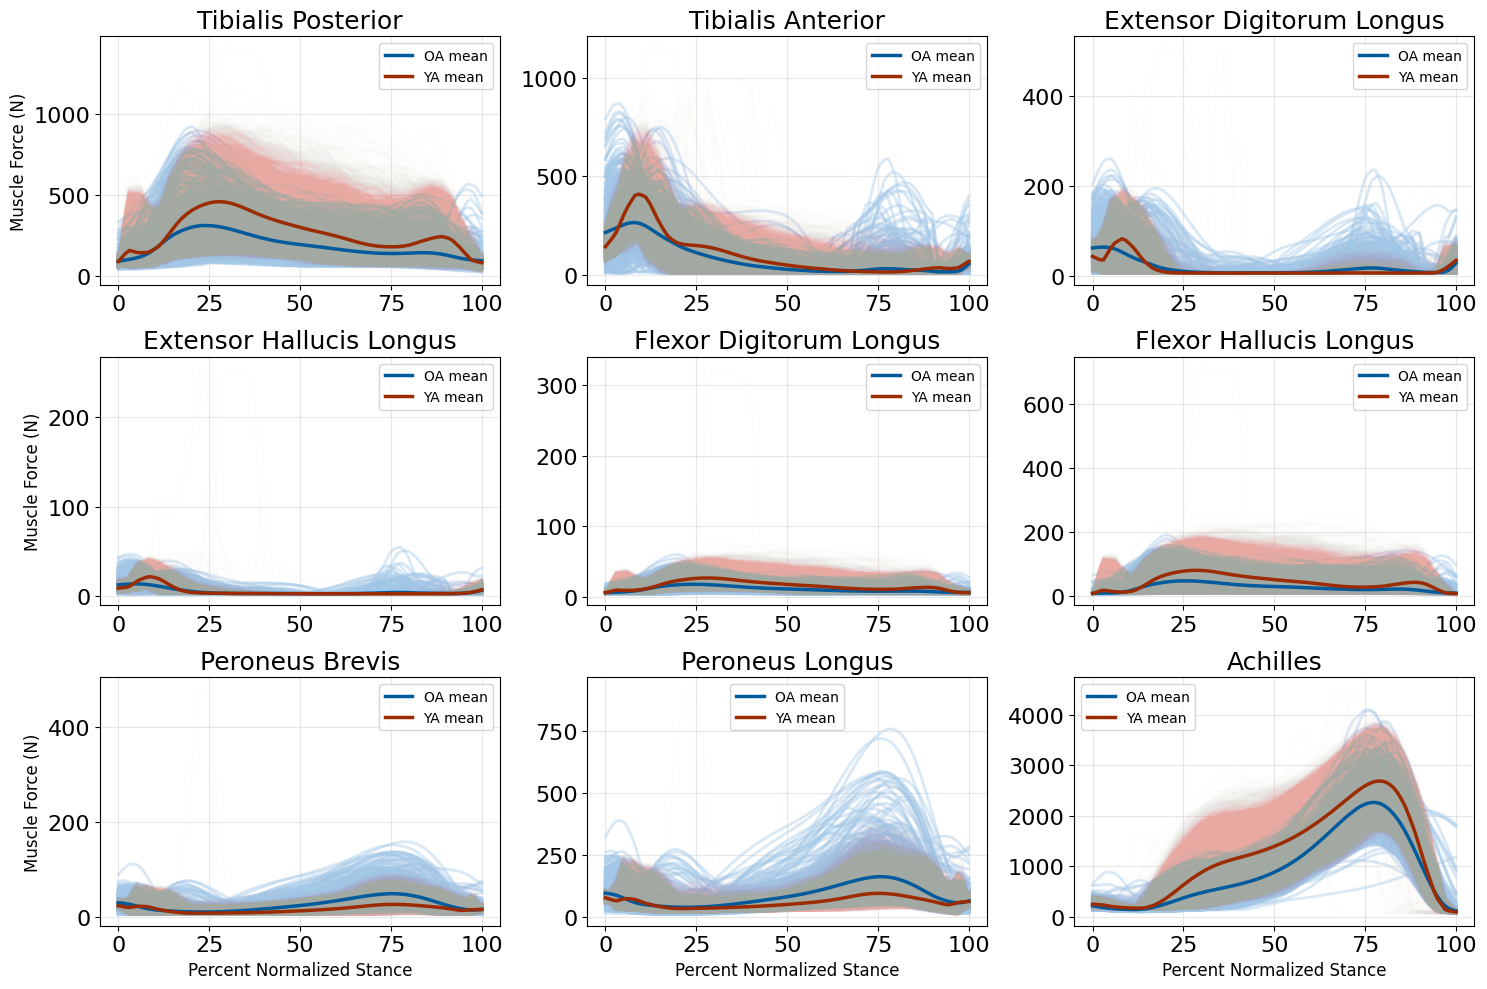

In [121]:
tony_dir = '/Users/briankeller/Desktop/GRFMuscleModel/data/'
tony_muscle_data = np.load(tony_dir + 'muscle.npy', mmap_mode='r')
n_tony_trials, n_timepoints, n_muscles = tony_muscle_data.shape
tony_muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i, ax in enumerate(axes):
    for j in range(num_achilles_segments):
        ax.plot(time_resampled[0]*100, muscle_forces[i][j], linewidth=2, color="#A2C7E7", alpha=0.4)
    for k in range(n_tony_trials):
         ax.plot(np.linspace(0, 100, n_timepoints), tony_muscle_data[k, :, i], linewidth=2, color="#E7A9A2", alpha=0.01)
    your_mean = np.mean(np.vstack(muscle_forces[i]), axis=0)
    tony_mean = np.mean(tony_muscle_data[:, :, i], axis=0)

    # --- Plot mean lines ---
    ax.plot(
        time_resampled[0] * 100,
        your_mean,
        color="#005A9C",
        linewidth=2.5,
        label='OA mean'
    )
    ax.plot(
        np.linspace(0, 100, n_timepoints),
        tony_mean,
        color="#9C2B00",
        linewidth=2.5,
        label='YA mean'
    )

    # Formatting
    ax.set_title(muscle_titles[i], fontsize=14)
    if i >= 6:
        ax.set_xlabel('Percent Stance (%)', fontsize=12)
    if i % 3 == 0:
        ax.set_ylabel('Force (N)', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(True, alpha=0.3)
    
    if i >= 6:
        ax.set_xlabel('Percent Normalized Stance', fontsize=12)
        
    if i % 3 == 0:
        ax.set_ylabel('Muscle Force (N)', fontsize=12)
        
    ax.set_title(muscle_titles[i], fontsize=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend()

plt.tight_layout()
plt.show()

In [126]:
with open('/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/OA_muscle_forces_stats_100.txt', "w") as file:
    for i, muscle in enumerate(muscle_titles):
        all_forces = np.concatenate(muscle_forces[i])
        # max_val = np.max(all_forces)
        # min_val = np.min(all_forces)
        max_vals = [np.max(seg) for seg in muscle_forces[i]]
        max_mean = np.mean(max_vals)
        max_std = np.std(max_vals)
        
        min_vals = [np.min(seg) for seg in muscle_forces[i]]
        min_mean = np.mean(min_vals)
        min_std = np.std(min_vals)
        
        mean_val = np.mean(all_forces)
        std_val = np.std(all_forces)
        
        print(f"{muscle}:\n Mean Max = {max_mean:.2f}\n Std Max = {max_std:.2f}\n Mean Min = {min_mean:.2f}\n Std Min = {min_std:.2f}\n Mean = {mean_val:.2f}\n Std = {std_val:.2f}\n")
        file.write(f"{muscle}:\n Mean Max = {max_mean:.2f}\n Std Max = {max_std:.2f}\n Mean Min = {min_mean:.2f}\n Std Min = {min_std:.2f}\n Mean = {mean_val:.2f}\n Std = {std_val:.2f}\n\n")

Tibialis Posterior:
 Mean Max = 352.28
 Std Max = 153.86
 Mean Min = 75.64
 Std Min = 18.70
 Mean = 186.25
 Std = 122.29

Tibialis Anterior:
 Mean Max = 331.67
 Std Max = 122.70
 Mean Min = 10.31
 Std Min = 2.15
 Mean = 80.35
 Std = 106.40

Extensor Digitorum Longus:
 Mean Max = 85.97
 Std Max = 43.81
 Mean Min = 5.45
 Std Min = 0.15
 Mean = 16.80
 Std = 26.62

Extensor Hallucis Longus:
 Mean Max = 17.70
 Std Max = 7.86
 Mean Min = 2.65
 Std Min = 0.05
 Mean = 4.88
 Std = 4.95

Flexor Digitorum Longus:
 Mean Max = 19.75
 Std Max = 8.79
 Mean Min = 4.68
 Std Min = 1.04
 Mean = 10.47
 Std = 6.75

Flexor Hallucis Longus:
 Mean Max = 61.05
 Std Max = 34.09
 Mean Min = 8.61
 Std Min = 0.26
 Mean = 27.38
 Std = 26.42

Peroneus Brevis:
 Mean Max = 55.50
 Std Max = 22.45
 Mean Min = 7.08
 Std Min = 2.97
 Mean = 24.72
 Std = 19.57

Peroneus Longus:
 Mean Max = 191.16
 Std Max = 95.94
 Mean Min = 28.53
 Std Min = 11.01
 Mean = 85.72
 Std = 68.54

Achilles:
 Mean Max = 2302.97
 Std Max = 450.12
 

In [123]:
with open('/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/OA_muscle_forces_stats_25.txt', "w") as file:
    for i, muscle in enumerate(muscle_titles):
        all_forces = np.concatenate(muscle_forces[i])
        # max_val = np.max(all_forces)
        # min_val = np.min(all_forces)
        max_vals = [np.max(seg) for seg in muscle_forces[i]]
        max_mean = np.mean(max_vals) / 4
        max_std = np.std(max_vals) / 4
        
        min_vals = [np.min(seg) for seg in muscle_forces[i]]
        min_mean = np.mean(min_vals) / 4
        min_std = np.std(min_vals) / 4
        
        mean_val = np.mean(all_forces) / 4
        std_val = np.std(all_forces) / 4
        
        print(f"{muscle}:\n Mean Max = {max_mean:.2f}\n Std Max = {max_std:.2f}\n Mean Min = {min_mean:.2f}\n Std Min = {min_std:.2f}\n Mean = {mean_val:.2f}\n Std = {std_val:.2f}\n")
        file.write(f"{muscle}:\n Mean Max = {max_mean:.2f}\n Std Max = {max_std:.2f}\n Mean Min = {min_mean:.2f}\n Std Min = {min_std:.2f}\n Mean = {mean_val:.2f}\n Std = {std_val:.2f}\n\n")

Tibialis Posterior:
 Mean Max = 88.07
 Std Max = 38.47
 Mean Min = 18.91
 Std Min = 4.68
 Mean = 46.56
 Std = 30.57

Tibialis Anterior:
 Mean Max = 82.92
 Std Max = 30.67
 Mean Min = 2.58
 Std Min = 0.54
 Mean = 20.09
 Std = 26.60

Extensor Digitorum Longus:
 Mean Max = 21.49
 Std Max = 10.95
 Mean Min = 1.36
 Std Min = 0.04
 Mean = 4.20
 Std = 6.66

Extensor Hallucis Longus:
 Mean Max = 4.42
 Std Max = 1.96
 Mean Min = 0.66
 Std Min = 0.01
 Mean = 1.22
 Std = 1.24

Flexor Digitorum Longus:
 Mean Max = 4.94
 Std Max = 2.20
 Mean Min = 1.17
 Std Min = 0.26
 Mean = 2.62
 Std = 1.69

Flexor Hallucis Longus:
 Mean Max = 15.26
 Std Max = 8.52
 Mean Min = 2.15
 Std Min = 0.06
 Mean = 6.84
 Std = 6.61

Peroneus Brevis:
 Mean Max = 13.88
 Std Max = 5.61
 Mean Min = 1.77
 Std Min = 0.74
 Mean = 6.18
 Std = 4.89

Peroneus Longus:
 Mean Max = 47.79
 Std Max = 23.99
 Mean Min = 7.13
 Std Min = 2.75
 Mean = 21.43
 Std = 17.13

Achilles:
 Mean Max = 575.74
 Std Max = 112.53
 Mean Min = 23.65
 Std Mi

Export dictionary of resampled grfs and muscle forces keyed to their respective subjects

In [124]:
export_path = '/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/resampled_compiled_segments'
with open(export_path, 'wb') as f:
    pickle.dump(resampled_segs, f)

In [125]:
grf = np.stack((grf_x_resampled, grf_y_resampled, grf_z_resampled), axis=-1)
grf.shape

(709, 100, 3)

In [93]:
np.save('/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/OA_no_missteps_grf', grf)

In [94]:
grf_flattened = np.hstack((grf_x_resampled, grf_y_resampled, grf_z_resampled))
grf_flattened.shape

(709, 300)

In [95]:
np.save('/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/OA_no_missteps_grf_flattened', grf_flattened)

In [96]:
muscle = np.stack((tibpost_resampled, tibant_resampled, edl_resampled, ehl_resampled, fdl_resampled, fhl_resampled, perbrev_resampled, perlong_resampled, achilles_resampled), axis=-1)
muscle.shape

(709, 100, 9)

In [97]:
np.save('/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/OA_no_missteps_muscle', muscle)

In [98]:
muscle_flattened = np.hstack((tibpost_resampled, tibant_resampled, edl_resampled, ehl_resampled, fdl_resampled, fhl_resampled, perbrev_resampled, perlong_resampled, achilles_resampled))
muscle_flattened.shape

(709, 900)

In [99]:
np.save('/Users/briankeller/Desktop/GRFMuscleModel/Old_Young_Walking_Data/OA_no_missteps_muscle_flattened', muscle_flattened)